In [1]:
%run "Common setup.ipynb"

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from SALib.analyze.delta import analyze

In [4]:
def incremental_delta_analysis(lower, upper, step=1):
    res, idx = [], []
    for reps in range(lower, upper, step):

        try:
            results = analyze(CIM_SPEC, numeric_vals[:reps], np_res[:reps], seed=101)
        except np.linalg.LinAlgError as e:
            res.append(np.nan)
            idx.append(reps)
            # print("error encountered: {}".format(e))
            continue

        total = results.to_df()

        res.append(total.loc[tgt_param, 'delta'])
        idx.append(reps)
    # End for
    
    return res, idx
# End incremental_delta_analysis()

In [5]:
numeric_samples = pd.read_csv(f'{DATA_DIR}saltelli_10_samples.csv', index_col=0)
numeric_samples = numeric_samples[perturbed_cols]
numeric_vals = numeric_samples.values

In [6]:
# Coupling disabled
# DMIM does not work when there is no change in parameter values

saltelli_no_irrigation_results = pd.read_csv(f'{DATA_DIR}saltelli_no_irrigation_10_results.csv', index_col=0)
saltelli_no_irrigation_results['Avg. $/ML'].fillna(saltelli_no_irrigation_results["Avg. Annual Profit ($M)"], inplace=True)

np_res = saltelli_no_irrigation_results.loc[:, tgt_metric].values

runs = np_res.shape[0]
res, idx = incremental_delta_analysis(54, runs+1, 54)

In [7]:
# plot_incremental_results(res, idx)
disabled = pd.DataFrame({'Delta': res}, index=idx)

In [8]:
# Coupling enabled

saltelli_with_irrigation_results = pd.read_csv(f'{DATA_DIR}saltelli_with_irrigation_10_results.csv', index_col=0)
saltelli_with_irrigation_results['Avg. $/ML'].fillna(saltelli_with_irrigation_results["Avg. Annual Profit ($M)"], inplace=True)

np_res = saltelli_with_irrigation_results.loc[:, tgt_metric].values

runs = np_res.shape[0]

res, idx = incremental_delta_analysis(54, runs+1, 54)

In [9]:
# plot_incremental_results(res, idx)
enabled = pd.DataFrame({'Delta': res}, index=idx)

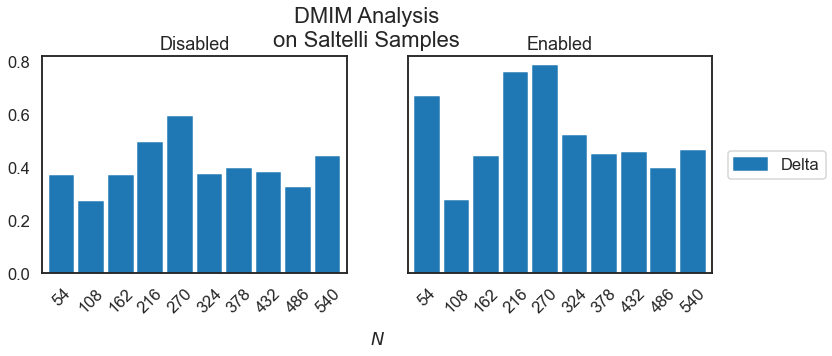

In [10]:
fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True, sharex=True)

disabled.loc[:, 'Delta'].plot(kind='bar', 
                           legend=None,
                           title='Disabled',
                           ax=axes[0],
                           use_index=True,
                           rot=45,
                           width=0.8,
                           edgecolor='C0')

enabled.loc[:, 'Delta'].plot(kind='bar', 
                          legend=None,
                          title='Enabled',
                          ax=axes[1],
                          use_index=True,
                          rot=45,
                          width=0.8,
                          edgecolor='C0').legend(
                             bbox_to_anchor=(1.4, 0.6)
                          )
fig.suptitle("DMIM Analysis\non Saltelli Samples", x=0.5, y=1.05, fontsize=22)

plt.xlabel("$N$", x=-0.1, labelpad=15);

In [11]:
fig.savefig(FIG_DIR+'DMIM_saltelli_delta_larger_sample.png', dpi=300, bbox_inches='tight')